# Modeling and Simulation in Python

Chapter 12

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [60]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code

Here's the code from the previous notebook that we'll need.

In [61]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [62]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [63]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [64]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

### Metrics

Given the results, we can compute metrics that quantify whatever we are interested in, like the total number of sick students, for example.

In [65]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

Here's an example.|

In [66]:
beta = 0.333
gamma = 0.25
system = make_system(beta, gamma)

results = run_simulation(system, update_func)
print(beta, gamma, calc_total_infected(results))

0.333 0.25 0.46716293183605073


**Exercise:** Write functions that take a `TimeFrame` object as a parameter and compute the other metrics mentioned in the book:

1.  The fraction of students who are sick at the peak of the outbreak.

2.  The day the outbreak peaks.

3.  The fraction of students who are sick at the end of the semester.

Note: Not all of these functions require the `System` object, but when you write a set of related functons, it is often convenient if they all take the same parameters.

Hint:  If you have a `TimeSeries` called `I`, you can compute the largest value of the series like this:

    I.max()

And the index of the largest value like this:

    I.idxmax()

You can read about these functions in the `Series` [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

In [67]:
#fraction of students sick at outbreak
def metric_func1(results):
    return results.I.max()
metric_func1(results)
    
    

0.043536202687592354

In [68]:
#the peak of the outbreak
def metric_func2(results):
    return results.I.idxmax()
metric_func2(results)

30

In [69]:
#fraction sick at the end

def metric_func3(results):
    return get_last_value(results.I)
metric_func3(results)

0.0006741943156034474

### What if?

We can use this model to evaluate "what if" scenarios.  For example, this function models the effect of immunization by moving some fraction of the population from S to R before the simulation starts.

In [70]:
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction

Let's start again with the system we used in the previous sections.

In [71]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

,values
init,S 0.988889 I 0.011111 R 0.000000 dtyp...
t0,0
t_end,98
beta,0.333333
gamma,0.25


And run the model without immunization.

In [72]:
results = run_simulation(system, update_func)
calc_total_infected(results)

0.468320811028781

Now with 10% immunization.

In [73]:
system2 = make_system(beta, gamma)
add_immunization(system2, 0.1)
results2 = run_simulation(system2, update_func)
calc_total_infected(results2)

0.30650802853979753

10% immunization leads to a drop in infections of 16 percentage points.

Here's what the time series looks like for S, with and without immunization.

Saving figure to file figs/chap05-fig02.pdf


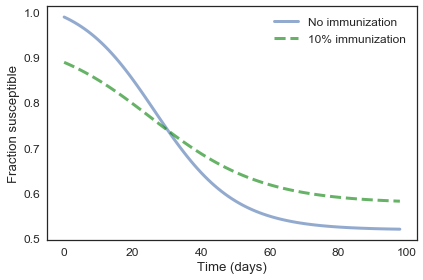

In [74]:
plot(results.S, '-', label='No immunization')
plot(results2.S, 'g--', label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

savefig('figs/chap05-fig02.pdf')

Now we can sweep through a range of values for the fraction of the population who are immunized.

In [75]:
immunize_array = linspace(0, 1, 11)
for fraction in immunize_array:
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    results = run_simulation(system, update_func)
    print(fraction, calc_total_infected(results))

0.0 0.468320811028781
0.1 0.30650802853979753
0.2 0.16136545700638427
0.30000000000000004 0.0728155898425179
0.4 0.03552021675299155
0.5 0.019688715782459176
0.6000000000000001 0.011622057998337987
0.7000000000000001 0.006838737800619332
0.8 0.003696496253713877
0.9 0.0014815326722661948
1.0 -0.00016121210941239666


This function does the same thing and stores the results in a `Sweep` object.

In [76]:
def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for fraction in immunize_array:
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        results = run_simulation(system, update_func)
        sweep[fraction] = calc_total_infected(results)
        
    return sweep

Here's how we run it.

In [77]:
immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

,values
0.00,0.468321
0.05,0.387288
0.10,0.306508
0.15,0.229234
0.20,0.161365
0.25,0.108791
0.30,0.072816
0.35,0.049938
0.40,0.035520
0.45,0.026121


And here's what the results look like.

Saving figure to file figs/chap05-fig03.pdf


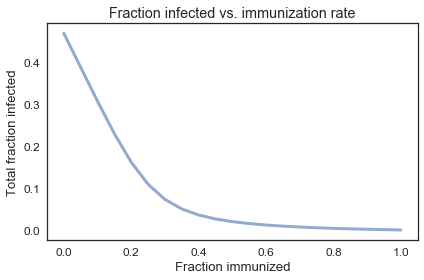

In [78]:
plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=False)

savefig('figs/chap05-fig03.pdf')

If 40% of the population is immunized, less than 4% of the population gets sick.

### Logistic function

To model the effect of a hand-washing campaign, I'll use a [generalized logistic function](https://en.wikipedia.org/wiki/Generalised_logistic_function) (GLF), which is a convenient function for modeling curves that have a generally sigmoid shape.  The parameters of the GLF correspond to various features of the curve in a way that makes it easy to find a function that has the shape you want, based on data or background information about the scenario.

In [79]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

The following array represents the range of possible spending.

In [80]:
spending = linspace(0, 1200, 21)

array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
        540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
       1080., 1140., 1200.])

`compute_factor` computes the reduction in `beta` for a given level of campaign spending.

`M` is chosen so the transition happens around \$500.

`K` is the maximum reduction in `beta`, 20%.

`B` is chosen by trial and error to yield a curve that seems feasible.

In [81]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=800, K=0.4, B=0.05)

Here's what it looks like.

Saving figure to file figs/chap05-fig04.pdf


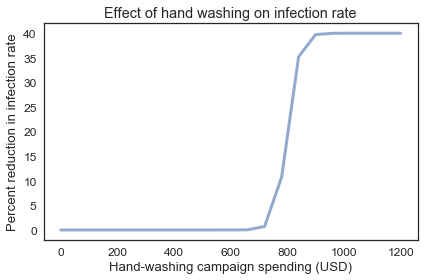

In [82]:
percent_reduction = compute_factor(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

savefig('figs/chap05-fig04.pdf')

**Exercise:** Modify the parameters `M`, `K`, and `B`, and see what effect they have on the shape of the curve.  Read about the [generalized logistic function on Wikipedia](https://en.wikipedia.org/wiki/Generalised_logistic_function).  Modify the other parameters and see what effect they have.

### Hand washing

Now we can model the effect of a hand-washing campaign by modifying `beta`

In [83]:
def add_hand_washing(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.beta *= (1 - factor)

Let's start with the same values of `beta` and `gamma` we've been using.

In [84]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

beta, gamma

(0.3333333333333333, 0.25)

Now we can sweep different levels of campaign spending.

In [85]:
spending_array = linspace(0, 1200, 13)

for spending in spending_array:
    system = make_system(beta, gamma)
    add_hand_washing(system, spending)
    results = run_simulation(system, update_func)
    print(spending, system.beta, calc_total_infected(results))

0.0 0.3333333333333333 0.468320811028781
100.0 0.33333333333333326 0.46832081102878065
200.0 0.3333333333333208 0.4683208110287378
300.0 0.3333333333314816 0.468320811022357
400.0 0.3333333330585128 0.4683208100753852
500.0 0.33333329254636973 0.4683206695322606
600.0 0.333327280284173 0.46829981154162215
700.0 0.33244095321009537 0.46521428858984637
800.0 0.26666666666666666 0.18734121837761575
900.0 0.20089238012323796 0.03911458853269245
1000.0 0.2000060530491603 0.03841525033634319
1100.0 0.2000000407869636 0.038410564401636926
1200.0 0.20000000027482048 0.038410532829244226


Here's a function that sweeps a range of spending and stores the results in a `SweepSeries`.

In [86]:
def sweep_hand_washing(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        results = run_simulation(system, update_func)
        sweep[spending] = calc_total_infected(results)
        
    return sweep

Here's how we run it.

In [87]:
spending_array = linspace(0, 1200, 20)
infected_sweep = sweep_hand_washing(spending_array)

,values
0.000000,0.468321
63.157895,0.468321
126.315789,0.468321
189.473684,0.468321
252.631579,0.468321
315.789474,0.468321
378.947368,0.468321
442.105263,0.468321
505.263158,0.468321
568.421053,0.468316


And here's what it looks like.

Saving figure to file figs/chap05-fig05.pdf


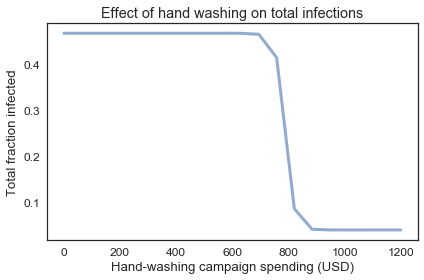

In [88]:
plot(infected_sweep)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections',
         legend=False)

savefig('figs/chap05-fig05.pdf')

Now let's put it all together to make some public health spending decisions.

### Optimization

Suppose we have \$1200 to spend on any combination of vaccines and a hand-washing campaign.

In [89]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses, endpoint=True)
max_doses

12

We can sweep through a range of doses from, 0 to `max_doses`, model the effects of immunization and the hand-washing campaign, and run simulations.

For each scenario, we compute the fraction of students who get sick.

In [90]:
for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    add_hand_washing(system, spending)
    
    results, run_simulation(system, update_func)
    print(doses, system.init.S, system.beta, calc_total_infected(results))

0.0 0.9888888888888889 0.20000000027482048 0.038410532829244226
1.0 0.9777777777777779 0.2000000407869636 0.038410532829244226
2.0 0.9666666666666667 0.2000060530491603 0.038410532829244226
3.0 0.9555555555555556 0.20089238012323796 0.038410532829244226
4.0 0.9444444444444445 0.26666666666666666 0.038410532829244226
5.0 0.9333333333333333 0.33244095321009537 0.038410532829244226
6.0 0.9222222222222223 0.333327280284173 0.038410532829244226
7.0 0.9111111111111112 0.33333329254636973 0.038410532829244226
8.0 0.9 0.3333333330585128 0.038410532829244226
9.0 0.888888888888889 0.3333333333314816 0.038410532829244226
10.0 0.8777777777777778 0.3333333333333208 0.038410532829244226
11.0 0.8666666666666667 0.33333333333333326 0.038410532829244226
12.0 0.8555555555555556 0.3333333333333333 0.038410532829244226


The following function wraps that loop and stores the results in a `Sweep` object.

In [91]:
def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results)

    return sweep

Now we can compute the number of infected students for each possible allocation of the budget.

In [92]:
infected_sweep = sweep_doses(dose_array)

,values
0,0.038411
1,0.036682
2,0.035063
3,0.034098
4,0.138180
5,0.375105
6,0.360207
7,0.342234
8,0.324314
9,0.306508


And plot the results.

Saving figure to file figs/chap05-fig06.pdf


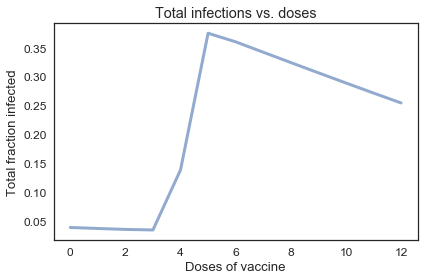

In [93]:
plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

savefig('figs/chap05-fig06.pdf')

### Exercises

**Exercise:** Suppose the price of the vaccine drops to $50 per dose.  How does that affect the optimal allocation of the spending?

**Exercise:** Suppose we have the option to quarantine infected students.  For example, a student who feels ill might be moved to an infirmary, or a private dorm room, until they are no longer infectious.

How might you incorporate the effect of quarantine in the SIR model?

0.0 0.9888888888888889 0.006122448988004708 0.038410532829244226
1.0 0.9777777777777779 0.006122449082081595 0.038410532829244226
2.0 0.9666666666666667 0.006122450228172355 0.038410532829244226
3.0 0.9555555555555556 0.006122464190364424 0.038410532829244226
4.0 0.9444444444444445 0.0061226342770151106 0.038410532829244226
5.0 0.9333333333333333 0.006124705218926218 0.038410532829244226
6.0 0.9222222222222223 0.006149766738466468 0.038410532829244226
7.0 0.9111111111111112 0.0064320742041683405 0.038410532829244226
8.0 0.9 0.008163265306122448 0.038410532829244226
9.0 0.888888888888889 0.009894456408076556 0.038410532829244226
10.0 0.8777777777777778 0.010176763873778428 0.038410532829244226
11.0 0.8666666666666667 0.01020182539331868 0.038410532829244226
12.0 0.8555555555555556 0.010203896335229785 0.038410532829244226
13.0 0.8444444444444446 0.010204066421880473 0.038410532829244226
14.0 0.8333333333333334 0.010204080384072542 0.038410532829244226
15.0 0.8222222222222223 0.010204081

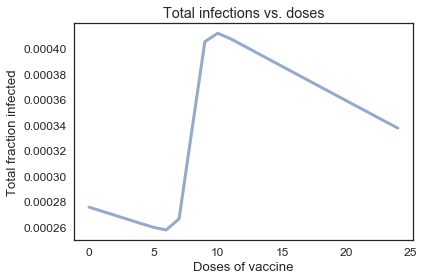

In [95]:
num_students = 90
budget = 1200
price_per_dose = 50
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses, endpoint=True)
max_doses

tc = 7*14      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

beta, gamma

for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    add_hand_washing(system, spending)
    
    results, run_simulation(system, update_func)
    print(doses, system.init.S, system.beta, calc_total_infected(results))
    
def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results)

    return sweep

infected_sweep = sweep_doses(dose_array)

plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

savefig('figs/chap12-fig01.pdf')